In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import numpy as np
import csv
from os import listdir
from os.path import isfile, join
import skfda
from skfda.representation.interpolation import SplineInterpolation
from skfda.exploratory.visualization import Boxplot
from numpy.polynomial.polynomial import polyfit
from random import *
from scipy.signal import argrelextrema

In [2]:
# Variabili globali

path = 'pala_ok/fullDischargeGoodmotor/'

In [3]:
allNI = []
allRPM = []
all_Volts = []

# Andiamo a prendere tutti i path dei vari file

path_acquisizioni = [f for f in listdir(path) if isfile(join(path, f))]

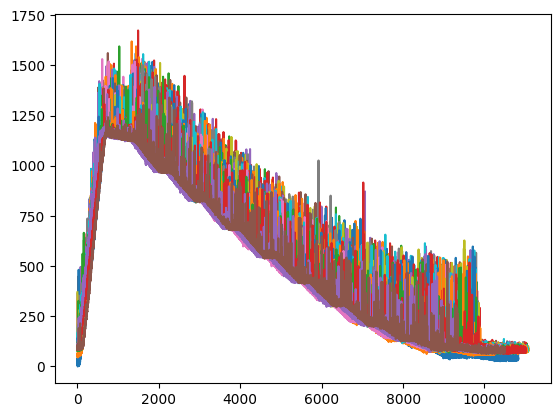

In [4]:
NiPrefix = 'measure_NI'
VoltsPrefix = 'measure_Volts'
RpMPrefix = 'measure_RPM'

for a in range(int(len(path_acquisizioni)/3)):
    allRPM.append(pd.read_csv(path+RpMPrefix+str(a)+'.csv',sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))
    all_Volts.append(pd.read_csv(path+VoltsPrefix+str(a)+'.csv',sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))
    try:
        allNI.append(pd.read_csv(path+NiPrefix+str(a)+'.csv',sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))
    except:
        df = pd.read_csv(path+NiPrefix+str(a)+'.csv',sep='\t').drop_duplicates(subset=['Time'],keep='last',ignore_index=True)
        allNI.append(df.rename(columns={"Time": "time"}))

        

allacqui = []
for a,b in zip(allNI,range(len(allNI))):
    allacqui.append([])
    a['Voltage'] = (10 - a['Voltage'])*500
    plt.plot(a['Voltage'])
    allacqui[-1].append(a)

In [5]:
def data_augmentation(df:pd.DataFrame,dimension:int):

    difference = dimension-df.shape[0]
    random_value = np.random.randint(min(df.index.to_list())+1,max(df.index.to_list())-1,difference)
    def sampleValues(index):
        time = df.columns.values[0]
        value = df.columns.values[1]
        new_value = (df.loc[index][value]+df.loc[index+1][value])/2
        new_timestamp = df.loc[index][time] + 1000
        return {time:new_timestamp, value:new_value}

    
    df = pd.concat([df, pd.DataFrame(list(map(sampleValues,random_value)))]).sort_values('time').reset_index(drop=True)

    return df
        


In [6]:
max_list = []

for a in allNI:
    max_list.append(a.shape[0])


In [7]:
#get PWN from the RPM data.
from scipy.signal import argrelextrema
def getPWM(DataFrameRPM):
    #Get PWN of RPM/Battery
    DataFrameMean = DataFrameRPM['rpm'].rolling(30,min_periods = 1,center=False).mean()
    gradient = np.gradient(DataFrameMean,np.arange(DataFrameMean.shape[0]))+np.random.uniform(low=0.0, high=0.1, size=DataFrameMean.shape[0])
    gradientDataframe = pd.DataFrame(gradient)
    ilocs_min = argrelextrema(gradient, np.less_equal, order=100)[0]
    ilocs_max = argrelextrema(gradient, np.greater_equal, order=100)[0]
    Minindexes = gradientDataframe.iloc[ilocs_min].nsmallest(10,0, keep='first').index.sort_values()
    def genpwm(x):
        res = 100
        for i in Minindexes:
            if x>i:
                res = res-10
        return res
    ranges = DataFrameRPM.index
    maxindex = gradientDataframe.iloc[ilocs_max].nlargest(1,0, keep='first')
    pwmRPM = list(map(genpwm,list(ranges)))
    pwmRPM[:maxindex.index[0]] = [0] * (maxindex.index[0])
        
    return pwmRPM

c:\Users\pc\anaconda3\envs\manutenzione\lib\site-packages\pandas\plotting\_matplotlib\core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)


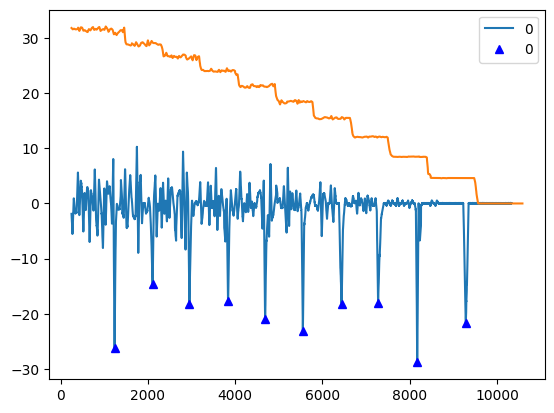

In [8]:


DataFrameMean = allRPM[0]['rpm'][250:].rolling(30,min_periods = 1,center=False).mean()

gradient = np.gradient(DataFrameMean,np.arange(DataFrameMean.shape[0]))+np.random.uniform(low=0.0, high=0.1, size=DataFrameMean.shape[0])
gradientDataframe = pd.DataFrame(gradient)

rollmax = np.array(pd.DataFrame(gradient).rolling(30,min_periods = 1,center=False).max())[:,0]
rollmaxDataframe = pd.DataFrame(gradient)

ilocs_min = argrelextrema(gradient, np.less_equal, order=100)[0]
ilocs_max = argrelextrema(gradient, np.greater_equal, order=100)[0]
Minindexes = gradientDataframe.iloc[ilocs_min].nsmallest(10,0, keep='first').index.sort_values()
fig, ax = plt.subplots(1, 1)
gradientDataframe[250:].plot(ax=ax)
(allRPM[0]['rpm'][250:]/300).plot(ax=ax)

gradientDataframe.iloc[Minindexes].plot(style='.', lw=10, color='blue', marker="^",ax=ax);

<Axes: >

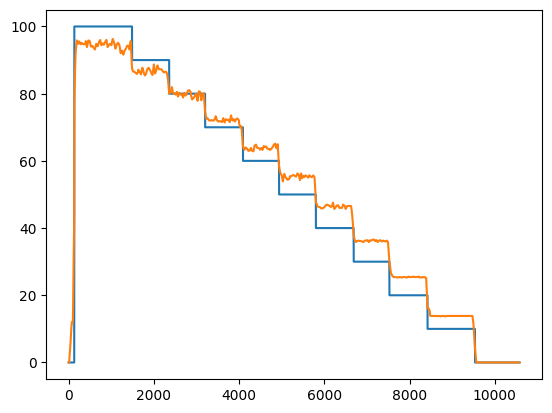

In [9]:
allPWM = [None] * len(allNI)
dim = max([len(allNI[0].index),len(allRPM[0].index),len(all_Volts[0].index)])

allPWM[0] = pd.DataFrame(getPWM(allRPM[0]),columns=['pwm'])
allPWM[0]['pwm'].plot()
(allRPM[0]['rpm']/100).plot()

In [10]:
allPWM = [None] * len(allNI)
pwm_min,pwm_max,pwm_offset = 1000,2000,1000
for ni,rpm,volt,indice in zip(allNI,allRPM,all_Volts,range(len(allNI))):
    dim = max([len(ni.index),len(rpm.index),len(volt.index)])

    allNI[indice] = data_augmentation(ni,dim).rolling(30,min_periods = 1,center=False).median()
    allRPM[indice] = data_augmentation(rpm,dim)
    all_Volts[indice] = data_augmentation(volt,dim)
    allPWM[indice] = pd.DataFrame(getPWM(allRPM[indice]),columns=['pwm'])

    cutIndex = allNI[indice].nlargest(1,'Voltage', keep='first').index[0]
    allPWM[indice] = allPWM[indice].iloc[cutIndex:]*pwm_offset/100+pwm_min
    all_Volts[indice] = all_Volts[indice].iloc[cutIndex:]
    allRPM[indice] = allRPM[indice].iloc[cutIndex:]
    allNI[indice] = allNI[indice].iloc[cutIndex:]

In [11]:
print(allNI[0])
maxindex = allNI[0].nlargest(1,'Voltage', keep='first').index[0]
print(maxindex)

               time      Voltage
695    1.684762e+15  1260.254436
696    1.684762e+15  1259.769806
697    1.684762e+15  1259.769806
698    1.684762e+15  1259.769806
699    1.684762e+15  1259.527491
...             ...          ...
10824  1.684762e+15    34.464322
10825  1.684762e+15    34.545094
10826  1.684762e+15    34.545094
10827  1.684762e+15    34.545094
10828  1.684762e+15    34.706637

[10134 rows x 2 columns]
695


<Axes: >

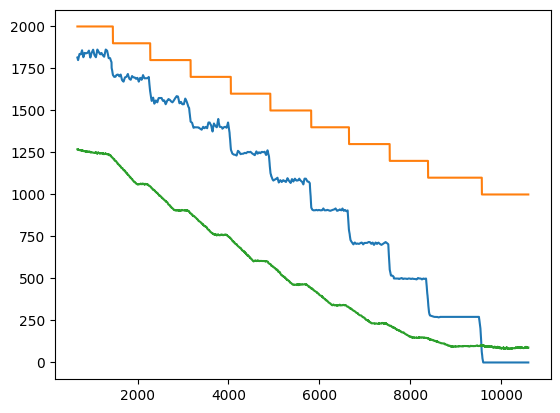

In [12]:
for a in range(len(allPWM)):
    allPWM[a].replace(to_replace=np.NaN, value=0,inplace = True)

for a in range(len(allRPM)):
    allRPM[a]['pwm'] = allPWM[a]

p = 10
(allRPM[p]['rpm']/5).plot()
allRPM[p]['pwm'].plot()
(allNI[p]['Voltage']).plot()

In [13]:
# Andiamo a definire un datagrid per ogni dataframe con NUOVE SPECIFICHE

all_data_grid = []
all_data_grid_pwm = []
for ni,rpm,pwm in zip(allNI,allRPM,allPWM):
        
    data_matrix = np.flip(np.array(ni[ni.columns.values[1]]))
    grid_points = np.flip(np.array(rpm[rpm.columns.values[1]]))

    all_data_grid.append(skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points=grid_points,
    dataset_name='Voltage - RPM',
    argument_names=(rpm.columns.values[1],),
    coordinate_names=(ni.columns.values[1],),
    interpolation=SplineInterpolation(interpolation_order=1)
    ))

    all_data_grid_pwm.append(skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points = np.flip(np.array(pwm[pwm.columns.values[0]])),
    dataset_name='Voltage - PWM',
    argument_names=(pwm.columns.values[0],),
    coordinate_names=(ni.columns.values[1],),
    interpolation=SplineInterpolation(interpolation_order=1)
    ))

c:\Users\pc\anaconda3\envs\manutenzione\lib\site-packages\skfda\exploratory\depth\multivariate.py:276: RuntimeWarning: invalid value encountered in divide
  return (  # type: ignore[no-any-return]


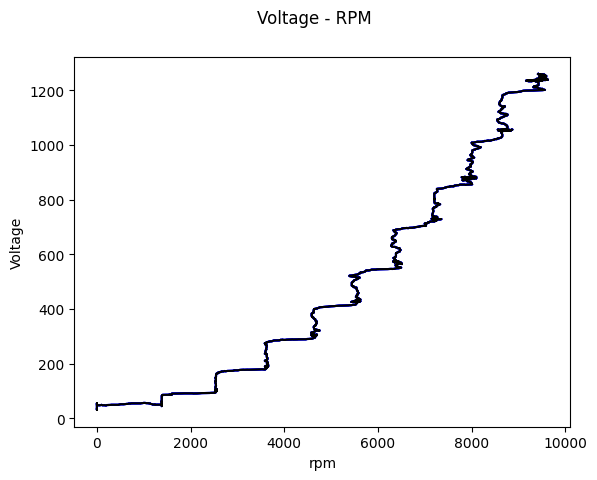

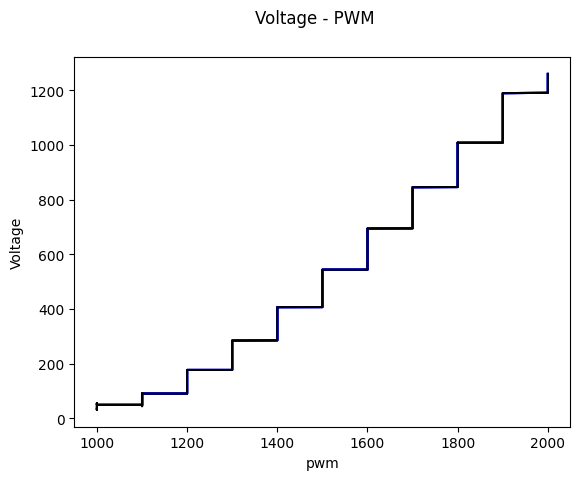

In [14]:
fdBoxplot = Boxplot(all_data_grid[0])
fdBoxplot.show_full_outliers = True
fdBoxplot.plot()
print()

fdBoxplot1 = Boxplot(all_data_grid_pwm[0])
fdBoxplot1.show_full_outliers = True
fdBoxplot1.plot()
print()

In [15]:
#Fitting for National Instrument
pol_maxGrade = 4
fit_result = []
fit_result_pwm = []
for i in range(pol_maxGrade):
    fit_result.append([])
    fit_result_pwm.append([])
    for j in range(len(all_data_grid)):
        fit_result[-1].append(polyfit(all_data_grid[j].grid_points[0],all_data_grid[j].data_matrix[0],deg=i+1))
        fit_result_pwm[-1].append(polyfit(all_data_grid_pwm[j].grid_points[0],all_data_grid_pwm[j].data_matrix[0],deg=i+1))



In [16]:
def makeColor(start:tuple = (1,0,0),end:tuple = (0,0,1),step:int = 46):
    if len(start)!=3 or len(end)!=3:
        raise Exception("not valid color")
    res = [None] * step
    for i in range(step):
        res[i] = (start[0]+(end[0] - start[0])*i/step,start[1]+(end[1] - start[1])*i/step,start[2]+(end[2] - start[2])*i/step,0.5)
    return res

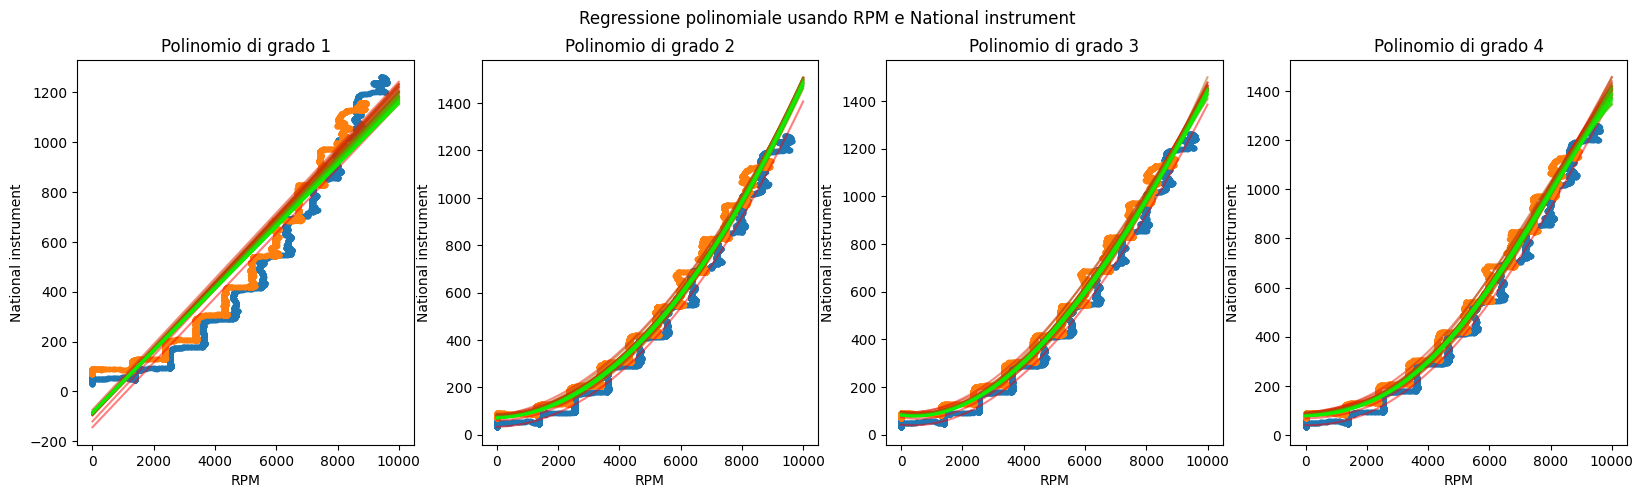

In [17]:
fig, axs = plt.subplots(nrows = 1, ncols = pol_maxGrade)
fig.set_size_inches(h=5,w=20)
min_rpm,max_rpm = 0,10000
colors = makeColor((1,0,0),(0,1,0))
linex = np.arange(min_rpm,max_rpm,1,dtype='longdouble')
fig.suptitle('Regressione polinomiale usando RPM e National instrument')

for grade_fit,grade in zip(fit_result,range(pol_maxGrade)):
        axs[grade].plot(all_data_grid[0].grid_points[0],all_data_grid[0].data_matrix[0],'.')
        axs[grade].plot(all_data_grid[len(all_data_grid)-1].grid_points[0],all_data_grid[len(all_data_grid)-1].data_matrix[0],'.')
        axs[grade].set_xlabel('RPM')
        axs[grade].set_ylabel('National instrument')
        axs[grade].set_title('Polinomio di grado '+str(grade+1))
        for fit,index in zip(grade_fit,range(len(grade_fit))):
                plotRes = np.array([0]*(max_rpm-min_rpm),dtype='longdouble')
                for i in range(len(fit)):
                        plotRes += np.multiply(fit[i],np.power(linex,i))
                axs[grade].plot(linex, plotRes,'-',color=colors[index])



C:\Users\pc\AppData\Local\Temp\ipykernel_2500\2765355046.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([all_Volts[45].iloc[-1]['volts'], all_Volts[36].iloc[-1]['volts'],all_Volts[27].iloc[-1]['volts'],all_Volts[18].iloc[-1]['volts'],all_Volts[9].iloc[-1]['volts'],all_Volts[0].iloc[-1]['volts']])  # horizontal colorbar


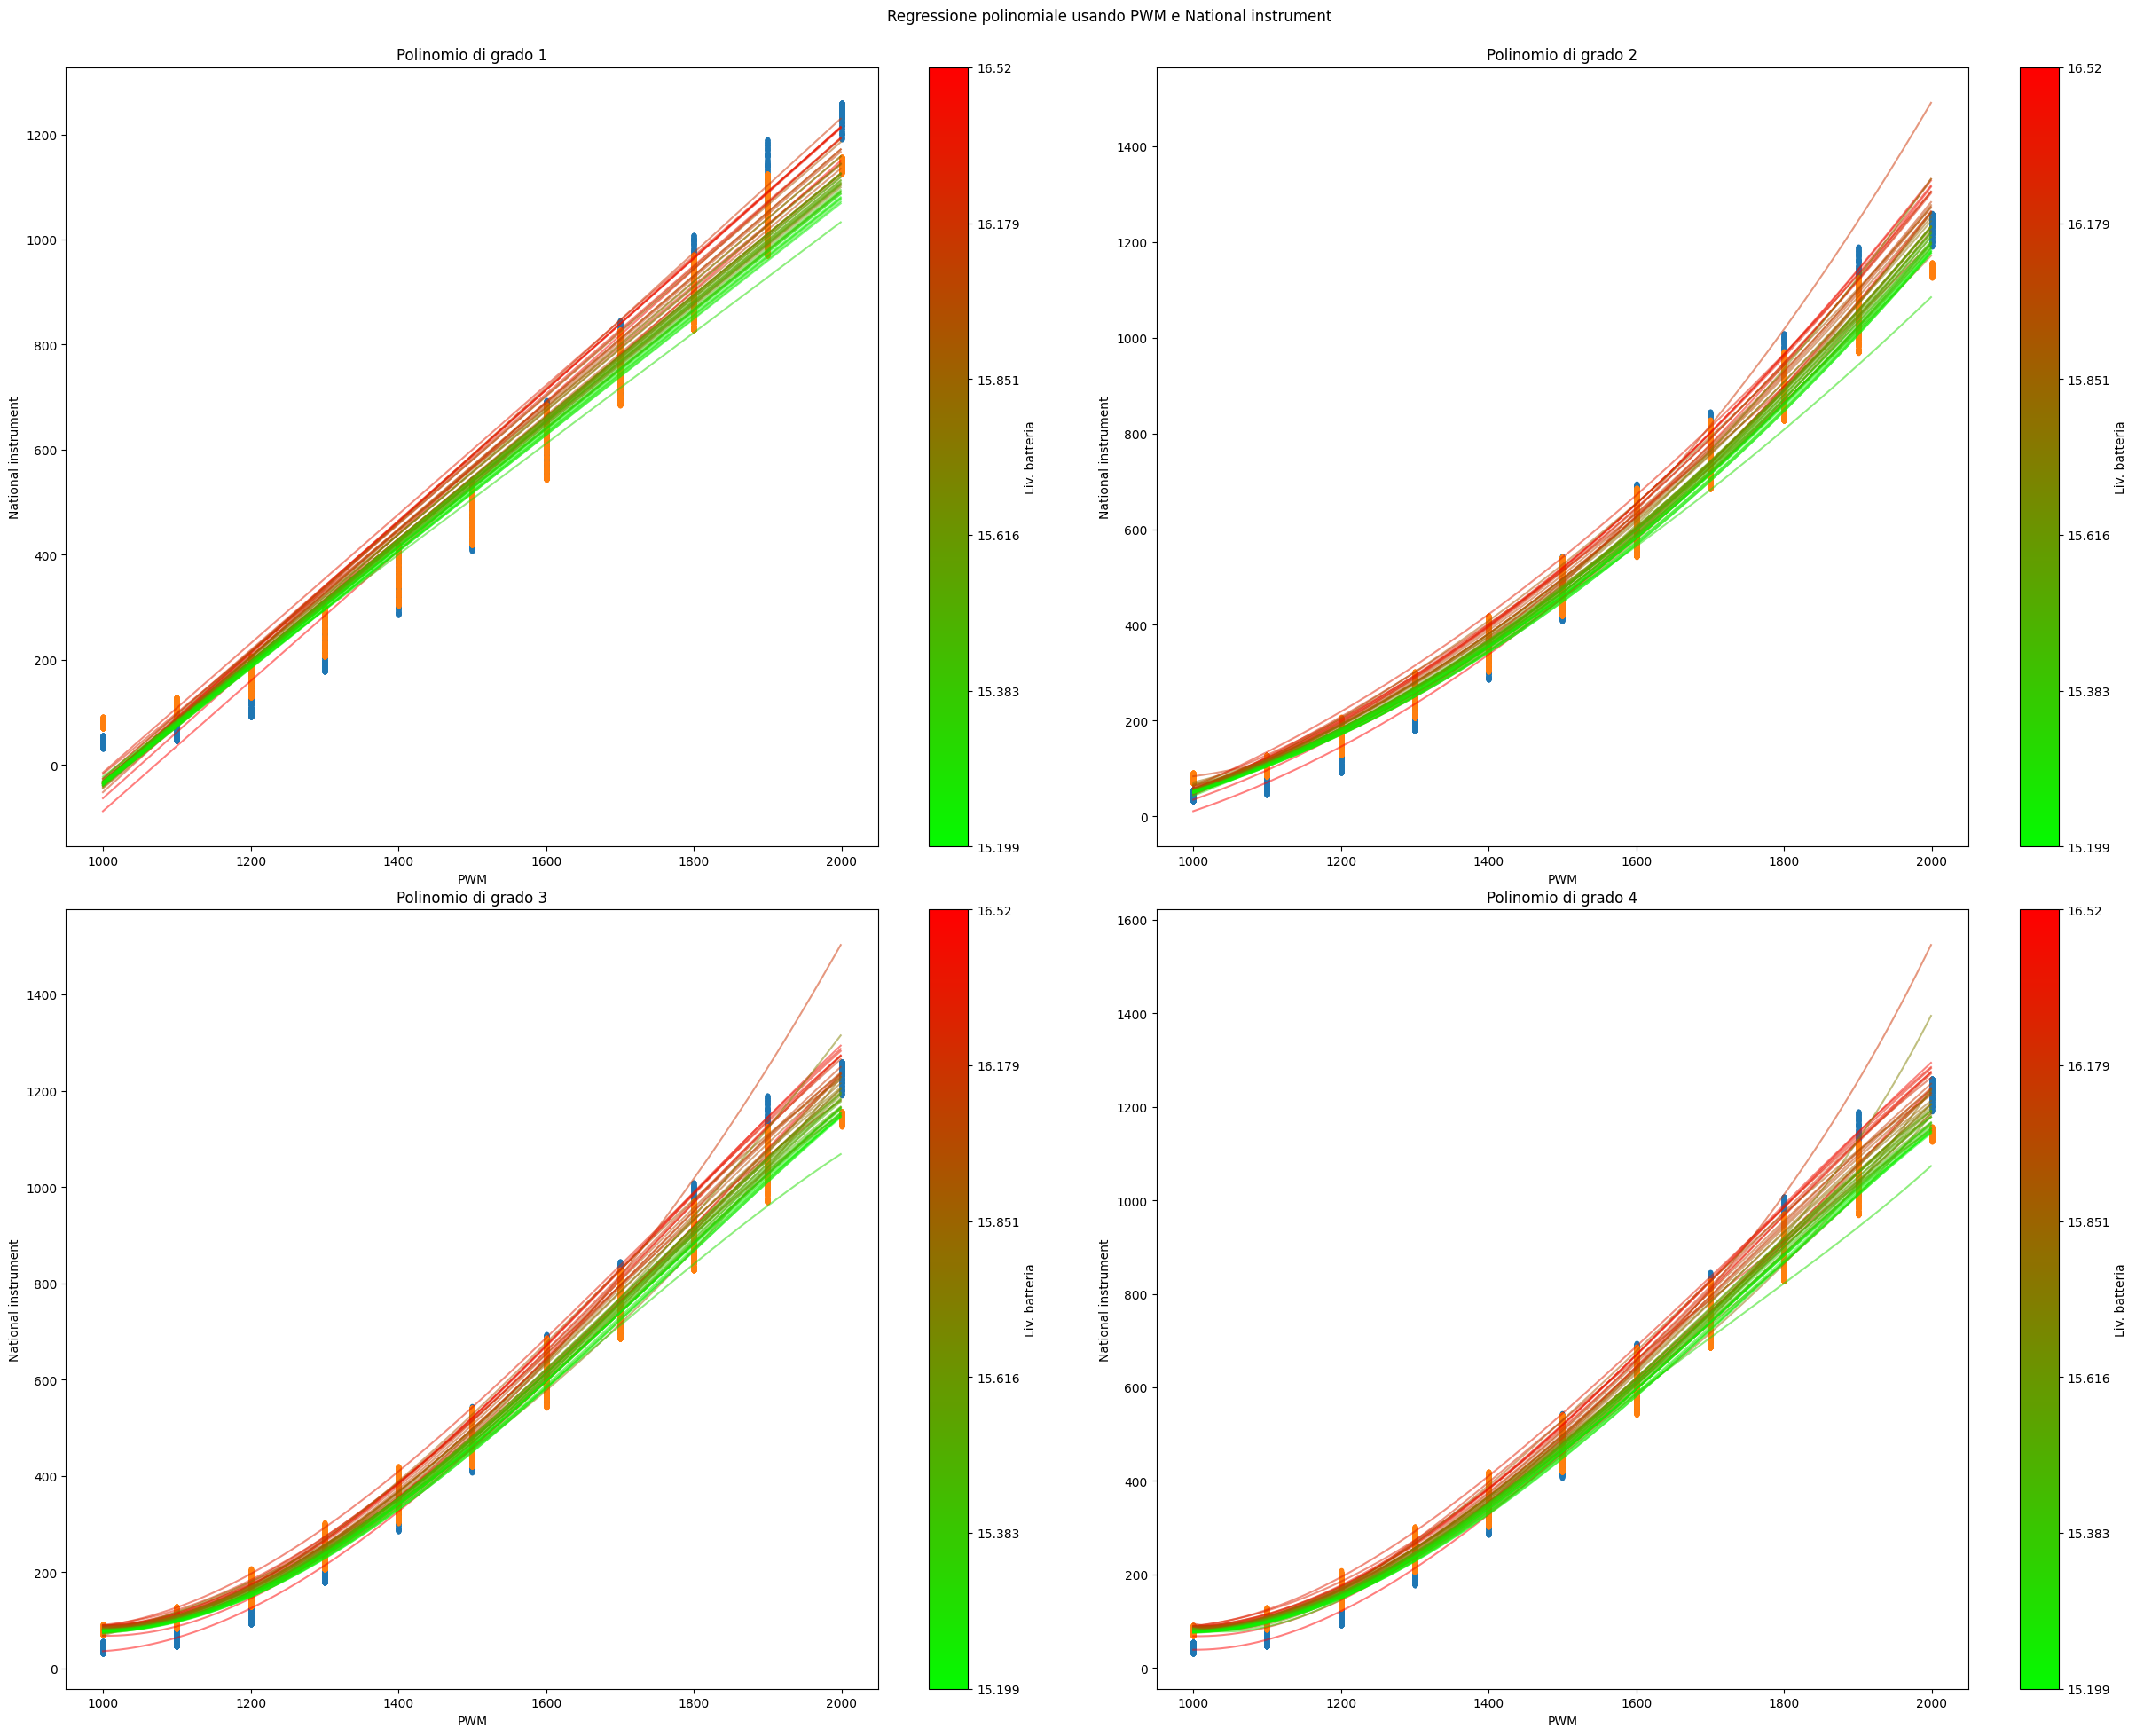

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.set_size_inches(h=20,w=25)
pwm_min,pwm_max = 1000,2000
colors = makeColor((1,0,0),(0,1,0))
inv_colors = makeColor((1,0,0),(0,1,0))
inv_colors.reverse()
linex = np.arange(pwm_min,pwm_max,1,dtype='longdouble')
fig.suptitle('Regressione polinomiale usando PWM e National instrument')
fig.tight_layout(pad=3)

for grade_fit,grade,axs in zip(fit_result_pwm,range(pol_maxGrade),[ax1, ax2, ax3, ax4]):
        axs.plot(all_data_grid_pwm[0].grid_points[0],all_data_grid_pwm[0].data_matrix[0],'.')
        axs.plot(all_data_grid_pwm[len(all_data_grid_pwm)-1].grid_points[0],all_data_grid_pwm[len(all_data_grid_pwm)-1].data_matrix[0],'.')
        axs.set_xlabel('PWM')
        axs.set_ylabel('National instrument')
        axs.set_title('Polinomio di grado '+str(grade+1))
        cmap = LinearSegmentedColormap.from_list('my_list', inv_colors)
        
        cbar = fig.colorbar(cm.ScalarMappable(norm=None, cmap=cmap), ax=axs)
        cbar.set_label(label='Liv. batteria')
        cbar.ax.set_yticklabels([all_Volts[45].iloc[-1]['volts'], all_Volts[36].iloc[-1]['volts'],all_Volts[27].iloc[-1]['volts'],all_Volts[18].iloc[-1]['volts'],all_Volts[9].iloc[-1]['volts'],all_Volts[0].iloc[-1]['volts']])  # horizontal colorbar
        for fit,index in zip(grade_fit,range(len(grade_fit))):
                plotRes = np.array([0]*(pwm_max-pwm_min),dtype='longdouble')
                for i in range(len(fit)):
                        plotRes += np.multiply(fit[i],np.power(linex,i))
                axs.plot(linex, plotRes,'-',color=colors[index])